Set to true if the notebook is on google colab

In [1]:
colab_notebook = False

### Import libraries

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
if colab_notebook:
    %pip install torchdiffeq
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.datasets import ImageFolder
import os, glob, random, shutil
from PIL import Image
import math
from torch.utils.data import Subset
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torchvision.transforms.functional import to_pil_image
from collections import Counter

/Users/micheledisabato/Documents/courses/WASPCourses/DeepLearning_WASP2025/deep-learning-m3/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/micheledisabato/Documents/courses/WASPCourses/DeepLearning_WASP2025/deep-learning-m3/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Set up the directory

In [3]:
if colab_notebook:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    dstn = "/content/drive" # location of where to save the data
else:
    dstn = os.path.join(os.getcwd(), 'data')

save_dir = os.path.join(os.getcwd(), 'results')

### Choose the dataset

In [4]:
data_identifier = 'MNIST'
# data_identifier = 'FashionMNIST'

### Choose the model

In [5]:
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")

from utils import UNetVectorField, CNFModel

if data_identifier == 'MNIST':
    state_FM = torch.load(os.path.join(os.getcwd(), 'results', 'model_state_7_FM.pth'), map_location=device)
    state_CNF = torch.load(os.path.join(os.getcwd(), 'results', 'model_state_7_CNF.pth'), map_location=device)['saved_models'][0][1]
if data_identifier == 'FashionMNIST':
    state_FM = torch.load(os.path.join(os.getcwd(), 'results', 'model_state_bag_FM.pth'), map_location=device)
    state_CNF = torch.load(os.path.join(os.getcwd(), 'results', 'model_state_bag_CNF.pth'), map_location=device)['saved_models'][-1][1]

levels = 3                                                                             # for 7 in MNIST
stride = 2**levels
field_FM = UNetVectorField(in_ch=1, base_ch=32, levels=levels, t_dim=256).to(device)   # for 7 in MNIST
field_FM.load_state_dict(state_FM)
field_FM.eval()

field_CNF = CNFModel(28*28)   # for 7 in MNIST
field_CNF.load_state_dict(state_CNF)
field_CNF.eval()

CNFModel(
  (f): RHSFunc(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=784, bias=True)
    (tanh): Tanh()
  )
)

### Load the MNIST dataset

/Users/micheledisabato/Documents/courses/WASPCourses/DeepLearning_WASP2025/deep-learning-m3/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


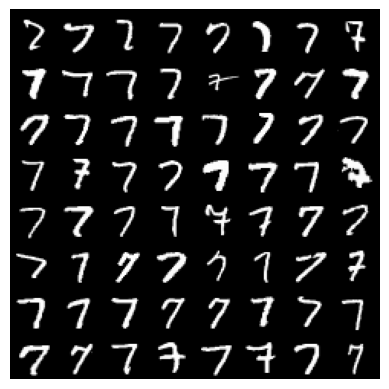

Batch shape: torch.Size([64, 1, 28, 28]) | unique labels: [7]
In total there are 6272 images


In [6]:
if data_identifier == 'MNIST':

    bs = 64 # batch size

    MNIST_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) 
    ])

    train_ds = datasets.MNIST(dstn, train=True,  download=True, transform=MNIST_tf)
    test_ds  = datasets.MNIST(dstn, train=False, download=True, transform=MNIST_tf)

    def only_digit_subset(ds, digit=1):
        """
        Keep only one class (digit) of the MNIST dataset
        """
        targets = getattr(ds, "targets", getattr(ds, "train_labels", None))
        idx = (targets == digit).nonzero(as_tuple=True)[0]
        return Subset(ds, idx)

    n = None # number of images to keep
    subset_train_ds = only_digit_subset(train_ds, 7)
    if n is not None:
        subset_train_ds = Subset(subset_train_ds, range(n))

    train_loader_MNIST = DataLoader(subset_train_ds, batch_size=bs, shuffle=True,  num_workers=0, pin_memory=False)
    test_loader_MNIST = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

    imgs, labels = next(iter(train_loader_MNIST))
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, value_range=(-1, 1))
    plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(-1), cmap="gray") # resize the image to make it of size (B, Channels, Height, Width)
    plt.axis("off"); plt.show()
    print("Batch shape:", imgs.shape, "| unique labels:", labels.unique().tolist())

    print(f"In total there are {len(train_loader_MNIST)*bs} images")

### Load the FashionMNIST dataset

In [7]:
if data_identifier == 'FashionMNIST':

    bs = 32

    fMNIST_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_ds = datasets.FashionMNIST(dstn, train=True,  download=True, transform=fMNIST_tf)
    test_ds  = datasets.FashionMNIST(dstn, train=False, download=True, transform=fMNIST_tf)

    fashion_classes = [
        "T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"
    ]
    def class_subset(ds, target):
        """
        Keep only one class
        """
        targets = getattr(ds, "targets", getattr(ds, "train_labels", None))
        if isinstance(target, str):
            cls_idx = fashion_classes.index(target)
        else:
            cls_idx = int(target)
        idx = (targets == cls_idx).nonzero(as_tuple=True)[0]
        return Subset(ds, idx), cls_idx

    n = None
    target_class = "Bag"
    subset_train_ds, cls_idx = class_subset(train_ds, target_class)
    if n is not None:
        train_one = Subset(subset_train_ds, range(n))

    train_loader_fMNIST = DataLoader(subset_train_ds, batch_size=bs, shuffle=True,  num_workers=0, pin_memory=False)
    test_loader_fMNIST  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

    imgs, labels = next(iter(train_loader_fMNIST))
    print(f"class kept: {fashion_classes[cls_idx]} (index {cls_idx})")
    print("Batch shape:", imgs.shape, "| unique labels:", labels.unique().tolist())

    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, value_range=(-1,1))
    plt.imshow(grid.permute(1,2,0).cpu().squeeze(-1), cmap="gray")
    plt.axis("off"); plt.show()

    print(f"In total there are {len(train_loader_fMNIST)*bs} images")

### Define necessary functions

In [8]:
def tensor_to_pil(x, mean=0.5, std=0.5):
    """
    x: CHW or BCHW tensor normalized with (x-mean)/std, here mean=std=0.5 (-> [-1,1]).
    Returns a PIL.Image (L for 1ch or RGB for 3ch).
    """
    if x.ndim == 4:
        x = x[0]
    x = x.detach().cpu().clone()
    # unnormalize back to [0,1]
    x = x * std + mean
    x = x.clamp(0, 1)

    if x.shape[0] == 1:  # grayscale
        arr = (x.squeeze(0).numpy() * 255).astype(np.uint8)     # HxW
        return Image.fromarray(arr, mode="L")
    else:                 # RGB
        arr = (x.permute(1,2,0).numpy() * 255).astype(np.uint8) # HxWxC
        return Image.fromarray(arr)


### Define the pre-trained models

/var/folders/m7/5tq1l9dj4ys9bm5s88nqph4m0000gn/T/ipykernel_87571/3853203344.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


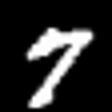

7


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 5023.12it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


7.0 7 0.9999979734420776


In [10]:
if data_identifier == 'MNIST':
    imgs, labels = next(iter(train_loader_MNIST))
    one_img_tensor = imgs[0]
    one_label = int(labels[0])
    mnist_pil = tensor_to_pil(one_img_tensor).convert("L")
    display(mnist_pil.resize((112,112)))
    print(one_label)
    mnist_model_id = "kenil-patel-183/mnist-cnn-digit-classifier"
    pt_model_proc = AutoImageProcessor.from_pretrained(
        mnist_model_id, trust_remote_code=True
    )
    pt_model = AutoModelForImageClassification.from_pretrained(
        mnist_model_id, trust_remote_code=True
    ).to(device).eval()
    inputs = pt_model_proc(images=mnist_pil, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = pt_model(**inputs)
    if hasattr(out, "logits"):
        logits = out.logits
    elif isinstance(out, dict):
        logits = out.get("logits", next(iter(out.values())))
    else:
        logits = out
    probs = torch.softmax(logits, dim=-1)[0]

    pred_idx  = int(probs.argmax())
    pred_name = pt_model.config.id2label.get(str(pred_idx), str(pred_idx))
    print(float(pred_idx), pred_name, float(probs[pred_idx]))


In [11]:
if data_identifier == 'FashionMNIST':

    fmnist_test_pil = datasets.FashionMNIST(dstn, train=False, download=True, transform=None)
    f_img_pil, f_label = fmnist_test_pil[1]  
    display(f_img_pil.resize((112,112)))
    print(f_label)

    fmnist_model_id = "prithivMLmods/Fashion-Mnist-SigLIP2"
    pt_model_proc  = AutoImageProcessor.from_pretrained(fmnist_model_id)
    pt_model = AutoModelForImageClassification.from_pretrained(fmnist_model_id).to(device).eval()

    f_img_rgb = f_img_pil.convert("RGB")

    inputs = pt_model_proc(images=f_img_rgb, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = pt_model(**inputs).logits
    probs = torch.softmax(logits, dim=-1)[0]

    pred_idx  = int(probs.argmax())
    pred_name = pt_model.config.id2label.get(str(pred_idx), str(pred_idx))
    print(pred_name, float(probs[pred_idx]))


### Generate images / load the generated images

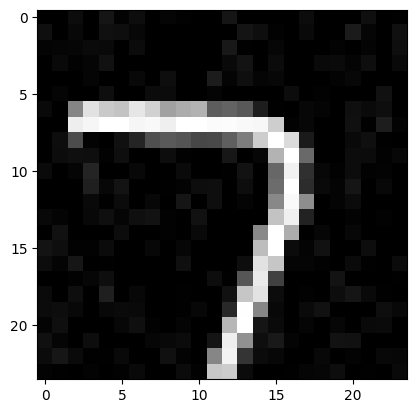

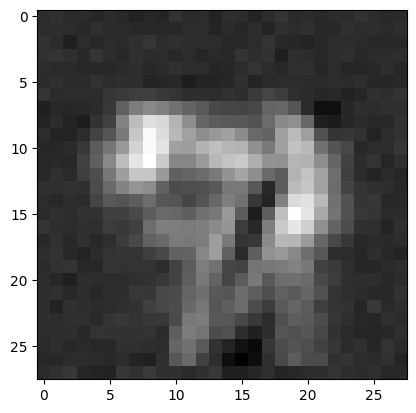

In [12]:
if data_identifier == 'MNIST':
    gens_FM = torch.load(os.path.join(save_dir, "generated_images_7_FM.pt"), map_location="cpu")  # {n: {"imgs": uint8 [C,H,W], "t_eval": tensor(…)}}
if data_identifier == 'FashionMNIST':
    gens_FM = torch.load(os.path.join(save_dir, "generated_images_bag_FM.pt"), map_location="cpu")  # {n: {"imgs": uint8 [C,H,W], "t_eval": tensor(…)}}


imgs_FM = torch.stack([gens_FM[k]["imgs"] for k in sorted(gens_FM)])      # [N,C,H,W], uint8
t_eval_FM = torch.stack([gens_FM[k]["t_eval"] for k in sorted(gens_FM)])  # [N]

with torch.no_grad():
    z0 = torch.randn(200, 28*28).to('cpu') # Random latent samples
    z1 = odeint(field_CNF.f, z0, torch.tensor([0.0, field_CNF.T]))[-1] # Integrating over the learned vector field f from 0 to T=1 to get z(1)=z1. Initial condition z(0)=z0.
    imgs_CNF = z1.view(-1, 1, 28, 28) # Reshape to images of shape (1, 28, 28).
    
plt.imshow(imgs_FM[21].permute(1,2,0).numpy(), cmap='gray')
plt.show()
imgs_CNF = [(((t.float() - t.min()) / (t.max() - t.min()).clamp_min(1e-8)) * 255).to(torch.uint8) for t in imgs_CNF]

plt.imshow(imgs_CNF[21].permute(1,2,0).numpy(), cmap='gray')
plt.show()

### Classify the images with the pretrained model

In [14]:
def use_pre_trained_model(imgs):
    imgs_pil = [to_pil_image(x).convert("RGB") for x in imgs]
    inputs = pt_model_proc(images=imgs_pil, return_tensors="pt")
    if hasattr(inputs, "to"):
        inputs = inputs.to(device)
    else:
        inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        out = pt_model(**inputs)
    if hasattr(out, "logits"):
        logits = out.logits
    elif isinstance(out, dict):
        logits = out.get("logits", next(iter(out.values())))
    elif isinstance(out, (list, tuple)):
        logits = out[0]
    else:
        logits = out
    probs = torch.softmax(logits, dim=-1)
    pred_ids   = probs.argmax(-1).detach().cpu().tolist()
    pred_probs = probs.max(-1).values.detach().cpu().tolist()
    pred_names = [pt_model.config.id2label.get(str(i), str(i)) for i in pred_ids]
    return pred_names


In [15]:
pred_names_FM = use_pre_trained_model(imgs_FM)
pred_names_CNF = use_pre_trained_model(imgs_CNF)

### Visualize performance of the pre-trained model

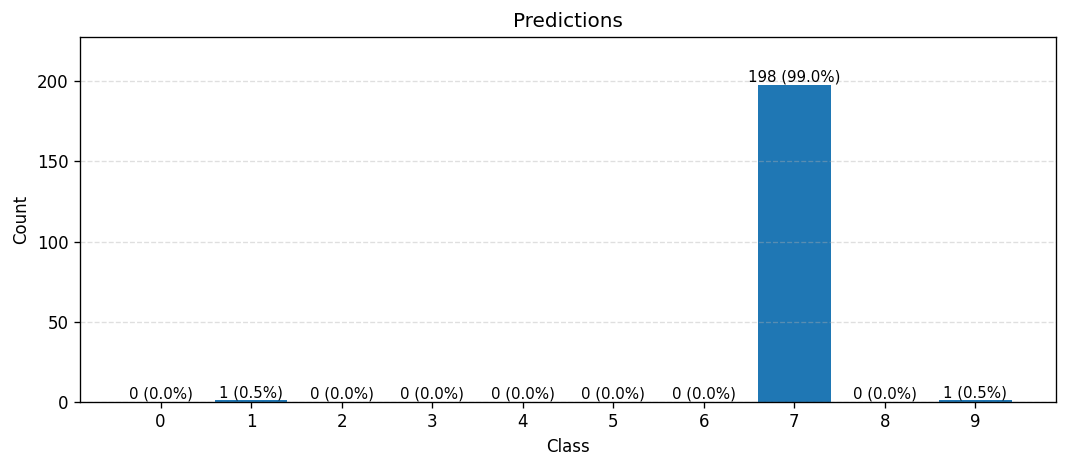

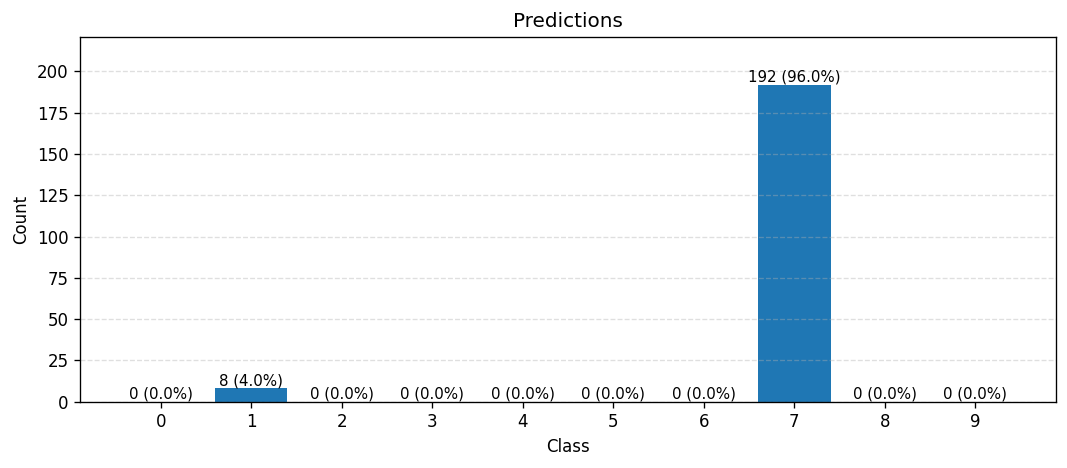

In [16]:
def plot_preditions(pred_names):
    labels = [str(i) for i in range(10)]  # change if needed

    cnt = Counter(pred_names)
    values = np.array([cnt.get(lbl, 0) for lbl in labels])
    N = int(values.sum())

    plt.figure(figsize=(9, 4), dpi=120)
    bars = plt.bar(labels, values)
    plt.title("Predictions"); plt.xlabel("Class"); plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.ylim(0, values.max()*1.15 if values.max()>0 else 1)

    for b, c in zip(bars, values):
        p = (c / N * 100) if N else 0
        plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{c} ({p:.1f}%)",
                ha="center", va="bottom", fontsize=9)

    plt.tight_layout(); plt.show()

plot_preditions(pred_names_FM)

plot_preditions(pred_names_CNF)

### See the misclassified samples

For example, see how many images were given label '5' instead of '7'

In [17]:
# target = "2"  # class to visualize
target = "6"  # class to visualize

idx = [i for i, n in enumerate(pred_names_FM) if str(n) == target]
k = min(len(idx), 25)
if k == 0:
    print(f"No images predicted as {target}.")
else:
    n_cols = 5
    n_rows = math.ceil(k / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), dpi=200)
    axes = axes.ravel() if hasattr(axes, "ravel") else [axes]
    for j in range(n_rows * n_cols):
        ax = axes[j]
        if j < k:
            ax.imshow(imgs_FM[idx[j]].permute(1,2,0).numpy(), cmap='gray')
            ax.set_title(f"idx {idx[j]}")
        ax.axis("off")
    plt.tight_layout(); plt.show()

idx = [i for i, n in enumerate(pred_names_CNF) if str(n) == target]
k = min(len(idx), 25)
if k == 0:
    print(f"No images predicted as {target}.")
else:
    n_cols = 5
    n_rows = math.ceil(k / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), dpi=200)
    axes = axes.ravel() if hasattr(axes, "ravel") else [axes]
    for j in range(n_rows * n_cols):
        ax = axes[j]
        if j < k:
            ax.imshow(imgs_CNF[idx[j]].permute(1,2,0).numpy(), cmap='gray')
            ax.set_title(f"idx {idx[j]}")
        ax.axis("off")
    plt.tight_layout(); plt.show()

No images predicted as 6.
No images predicted as 6.
